## Vision Transformer (ViT)

This notebook implements and trains a Vision Transformer. We  start to build our own ViT model and train it on an image classification task.

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# VIT Implementation

The vision transformer can be separated into three parts, we will implement each part and combine them in the end.

ViT implementation details are available at: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py and https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py

## PatchEmbedding
PatchEmbedding is responsible for dividing the input image into non-overlapping patches and projecting them into a specified embedding dimension. It uses a 2D convolution layer with a kernel size and stride equal to the patch size. The output is a sequence of linear embeddings for each patch.

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super().__init__()

        self.conv_layer = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        embedded = self.conv_layer(x)
        embedded = embedded.flatten(2).transpose(1, 2)
        return embedded


## MultiHeadSelfAttention

This class implements the multi-head self-attention mechanism, which is a key component of the transformer architecture. It consists of multiple attention heads that independently compute scaled dot-product attention on the input embeddings. This allows the model to capture different aspects of the input at different positions. The attention outputs are concatenated and linearly transformed back to the original embedding size.

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.linear = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        # Apply linear projections for queries, keys, and values, and reshape
        query = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        key = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        value = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Compute scaled dot-product attention
        scores = query.matmul(key.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention = self.dropout(torch.softmax(scores, dim=-1)) # softargmax
        out = attention.matmul(value).transpose(1, 2).reshape(batch_size, seq_len, embed_dim)
        # Apply output projection with droput
        out = self.linear(out)
        out = self.dropout(out)

        # Add residual
        out += x
        
        return out


## TransformerBlock
This class represents a single transformer layer. It includes a multi-head self-attention sublayer followed by a position-wise feed-forward network (MLP). Each sublayer is surrounded by residual connections.

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout):
        super().__init__()

        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.layer_norm1 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x_norm = self.layer_norm1(x)
        # Compute attention
        attn_out = self.attention(x_norm)
        # Add residual
        attn_out = attn_out + x
        attn_out_norm = self.layer_norm2(attn_out)
        # Apply feed forward network
        mlp_out = self.mlp(attn_out_norm)
        # Add residual
        mlp_out = mlp_out + attn_out
        out = self.dropout(mlp_out)
        return out


## VisionTransformer:
This is the main class that assembles the entire Vision Transformer architecture. It starts with the PatchEmbedding layer to create patch embeddings from the input image. A special class token is added to the sequence, and positional embeddings are added to both the patch and class tokens. The sequence of patch embeddings is then passed through multiple TransformerBlock layers. The final output is the logits for all classes.

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim, num_heads, mlp_dim, num_layers, num_classes, dropout=0.1):
        super().__init__()

        num_patches = (image_size // patch_size) ** 2

        self.patch_embedding = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.positional_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_dim, dropout) for i in range(num_layers)
        ])

        self.linear = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # Get patch embeddings
        x = self.patch_embedding(x).flatten(2).transpose(1, 2)
        # Get class tokens
        class_token = self.class_token.expand(x.shape[0], -1, -1)
        # Concatenate class tokens to sequence
        x = torch.cat([class_token, x], dim=1)
        # Add positional embeddings
        x = x + self.positional_embeddings
        # Add dropout
        x = self.dropout(x)
        # Run transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer(x)
        # Apply linear layer
        out = self.linear(x[:, 0, :])
        return out

## Training

We train the ViT to do the image classification with CIFAR100.

In [19]:
image_size = 32
patch_size = 4
in_channels = 3
embed_dim = 256
num_heads = 8
mlp_dim = 512
num_layers = 8
num_classes = 100
dropout = 0.1

batch_size = 32

In [16]:
model = VisionTransformer(image_size, patch_size, in_channels, embed_dim, num_heads, mlp_dim, num_layers, num_classes, dropout).to(device)
print(sum(p.numel() for p in model.parameters()))

input_tensor = torch.randn(1, in_channels, image_size, image_size).to(device)
output = model(input_tensor)
print(output.shape)

4271972
torch.Size([1, 100])


In [9]:
# Load the CIFAR-100 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


## Training

We use 4 different training sections with decreasing learning rates, and switch to the next section (with a lower learning rate) when validation accuracy stops increasing.

In [65]:
'''
SECTION 1: LR = 0.001
'''

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from tqdm.notebook import tqdm

# Train the model
num_epochs = 100
best_val_acc = 0
validation_accs1 = []
for epoch in range(num_epochs):
    model.train()
    for i, data in tqdm(enumerate(trainloader, 0), total=((len(trainset)//batch_size) + 1)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    validation_accs1.append(val_acc)
    print(f"Epoch: {epoch + 1}, Validation Accuracy: {val_acc:.2f}%")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1, Validation Accuracy: 15.48%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2, Validation Accuracy: 19.16%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3, Validation Accuracy: 21.18%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4, Validation Accuracy: 24.08%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5, Validation Accuracy: 27.31%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6, Validation Accuracy: 29.81%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7, Validation Accuracy: 31.88%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8, Validation Accuracy: 33.18%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9, Validation Accuracy: 34.49%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10, Validation Accuracy: 35.04%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11, Validation Accuracy: 38.03%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12, Validation Accuracy: 36.17%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13, Validation Accuracy: 38.12%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14, Validation Accuracy: 38.98%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15, Validation Accuracy: 40.74%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16, Validation Accuracy: 41.63%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17, Validation Accuracy: 42.72%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18, Validation Accuracy: 43.28%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19, Validation Accuracy: 44.12%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 20, Validation Accuracy: 45.22%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 21, Validation Accuracy: 43.85%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 22, Validation Accuracy: 45.15%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 23, Validation Accuracy: 47.06%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 24, Validation Accuracy: 46.23%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 25, Validation Accuracy: 47.26%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 26, Validation Accuracy: 47.91%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 27, Validation Accuracy: 46.65%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 28, Validation Accuracy: 47.62%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 29, Validation Accuracy: 48.47%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 30, Validation Accuracy: 47.42%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 31, Validation Accuracy: 49.11%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 32, Validation Accuracy: 49.88%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 33, Validation Accuracy: 49.57%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 34, Validation Accuracy: 49.19%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 35, Validation Accuracy: 50.00%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 36, Validation Accuracy: 49.62%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 37, Validation Accuracy: 49.56%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 38, Validation Accuracy: 50.34%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 39, Validation Accuracy: 51.90%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 40, Validation Accuracy: 52.27%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 41, Validation Accuracy: 50.83%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 42, Validation Accuracy: 52.43%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 43, Validation Accuracy: 53.13%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 44, Validation Accuracy: 52.63%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 45, Validation Accuracy: 52.52%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 46, Validation Accuracy: 52.75%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 47, Validation Accuracy: 53.01%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 48, Validation Accuracy: 53.10%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 49, Validation Accuracy: 53.39%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 50, Validation Accuracy: 53.77%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 51, Validation Accuracy: 54.27%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 52, Validation Accuracy: 54.03%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 53, Validation Accuracy: 54.04%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 54, Validation Accuracy: 53.61%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 55, Validation Accuracy: 52.94%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 56, Validation Accuracy: 54.32%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 57, Validation Accuracy: 52.84%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 58, Validation Accuracy: 55.90%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 59, Validation Accuracy: 54.24%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 60, Validation Accuracy: 55.61%


  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [66]:
'''
SECTION 2: LR = 0.0005
'''

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

from tqdm.notebook import tqdm

# Train the model
num_epochs = 100
best_val_acc = 0
validation_accs2 = []
for epoch in range(num_epochs):
    model.train()
    for i, data in tqdm(enumerate(trainloader, 0), total=((len(trainset)//batch_size) + 1)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    validation_accs2.append(val_acc)
    print(f"Epoch: {epoch + 1}, Validation Accuracy: {val_acc:.2f}%")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5546bc670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5546bc670>
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 1, Validation Accuracy: 58.17%


  0%|          | 0/1563 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5546bc670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5546bc670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 2, Validation Accuracy: 58.76%


  0%|          | 0/1563 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5546bc670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5546bc670>
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in

Epoch: 3, Validation Accuracy: 58.89%


  0%|          | 0/1563 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5546bc670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5546bc670>

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 4, Validation Accuracy: 59.17%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5, Validation Accuracy: 59.11%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6, Validation Accuracy: 57.97%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7, Validation Accuracy: 58.72%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8, Validation Accuracy: 58.76%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9, Validation Accuracy: 58.40%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10, Validation Accuracy: 58.93%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11, Validation Accuracy: 59.51%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12, Validation Accuracy: 58.67%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13, Validation Accuracy: 59.50%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14, Validation Accuracy: 59.04%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15, Validation Accuracy: 59.93%


  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [67]:
'''
SECTION 3: LR = 0.0001
'''

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

from tqdm.notebook import tqdm

# Train the model
num_epochs = 100
best_val_acc = 0
validation_accs3 = []
for epoch in range(num_epochs):
    model.train()
    for i, data in tqdm(enumerate(trainloader, 0), total=((len(trainset)//batch_size) + 1)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    validation_accs3.append(val_acc)
    print(f"Epoch: {epoch + 1}, Validation Accuracy: {val_acc:.2f}%")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1, Validation Accuracy: 61.23%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2, Validation Accuracy: 61.28%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3, Validation Accuracy: 61.45%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4, Validation Accuracy: 61.54%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5, Validation Accuracy: 61.72%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6, Validation Accuracy: 61.66%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7, Validation Accuracy: 61.74%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8, Validation Accuracy: 61.24%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9, Validation Accuracy: 61.91%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10, Validation Accuracy: 61.69%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11, Validation Accuracy: 61.72%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12, Validation Accuracy: 61.87%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13, Validation Accuracy: 61.16%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14, Validation Accuracy: 61.36%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15, Validation Accuracy: 61.79%


  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [94]:
'''
SECTION 4: LR = 0.00005
'''

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

from tqdm.notebook import tqdm

# Train the model
num_epochs = 100
best_val_acc = 0
validation_accs4 = []
for epoch in range(num_epochs):
    model.train()
    for i, data in tqdm(enumerate(trainloader, 0), total=((len(trainset)//batch_size) + 1)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    validation_accs4.append(val_acc)
    print(f"Epoch: {epoch + 1}, Validation Accuracy: {val_acc:.2f}%")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1, Validation Accuracy: 62.10%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2, Validation Accuracy: 61.99%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3, Validation Accuracy: 62.19%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4, Validation Accuracy: 61.95%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5, Validation Accuracy: 61.86%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6, Validation Accuracy: 61.79%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7, Validation Accuracy: 61.70%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8, Validation Accuracy: 61.86%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9, Validation Accuracy: 61.99%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10, Validation Accuracy: 62.12%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11, Validation Accuracy: 62.22%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12, Validation Accuracy: 62.05%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13, Validation Accuracy: 62.02%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14, Validation Accuracy: 61.74%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15, Validation Accuracy: 61.68%


  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Please submit your best_model.pth with this notebook. And report the best test results you get.

## Visualisation

105
105


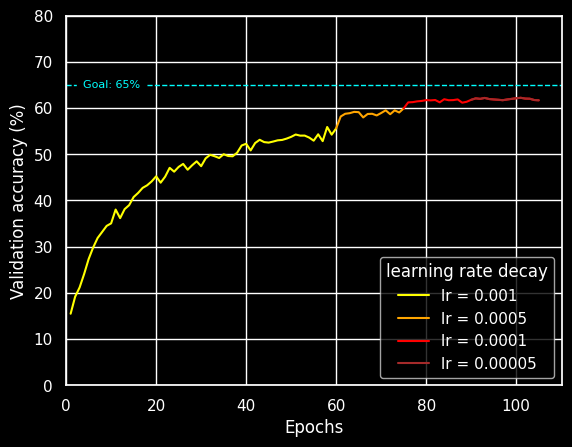

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('dark_background')

validation_accs = validation_accs1 + validation_accs2 + validation_accs3 + validation_accs4
epochs = list(range(1, len(validation_accs)+1))
print(len(validation_accs))
print(len(epochs))

len1, len2, len3, len4 = len(validation_accs1), len(validation_accs2), len(validation_accs3), len(validation_accs4)

plt.plot(epochs[:len1], validation_accs[:len1], color='yellow', label='lr = 0.001')
plt.plot(epochs[len1-1:len1+len2], validation_accs[len1-1:len1+len2], color='orange', label='lr = 0.0005')
plt.plot(epochs[len1+len2-1:], validation_accs[len1+len2-1:], color='red', label='lr = 0.0001')
plt.plot(epochs[len1+len2+len3-1:], validation_accs[len1+len2+len3-1:], color='brown', label='lr = 0.00005')
plt.axhline(y=65, color='cyan', linestyle='--', linewidth=1)
plt.text(10, 65, 'Goal: 65%', fontsize=8, color='cyan', va='center', ha='center', backgroundcolor='black')
plt.xlim(xmin=0)
plt.ylim(ymin=0, ymax=80)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy (%)')
plt.legend(title='learning rate decay', loc='lower right')
plt.show()

Best validation accuracy: 62.22%